# Deepdive notebook converted to plot proper figures

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from numpy import core
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
from functions import *
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch
import pickle


In [2]:
from env_lite import Environment
from model import NN
import json
import numpy as np

In [3]:
# load parameters from json file
params_path = "params.json"
# Open the file and read the contents
with open(params_path, "r") as f:
    parameters = json.load(f)

In [4]:
# running conditions
N_DAILY_MOTIFS = parameters['params']['TRIALS'] # trials per day per syllable  # old code TRIALS
TRIALS = N_DAILY_MOTIFS
DAYS = parameters['params']['DAYS'] # days for learning
N_SYLL = parameters['params']['N_SYLL'] # number of syllables   
if N_SYLL > 5 or N_SYLL < 1:
    ValueError('Invalid number of syllables')
RANDOM_SEED = 41
print(f'Random seed is {RANDOM_SEED}')
# np.random.seed(RANDOM_SEED)
load = True # load model
save = 0 # save model    

Random seed is 41


In [5]:
if load:
    # load model
    with open('model.pkl', 'rb') as f:
        obj = pickle.load(f)
        print("Model loaded successfully!") 
else:
    obj = Environment(RANDOM_SEED, parameters, NN)
    obj.run(parameters, True)
    if save:
        try:
            pickle.dumps(obj)  # Test serialization
            print("Object can be pickled!")
        except pickle.PicklingError:
            print("Object cannot be pickled!")
        with open("model.pkl", "wb") as f:
            pickle.dump(obj, f)

Model loaded successfully!


In [6]:
import sys

def analyze_object_size(obj):
    """Prints the size of each attribute inside an object."""
    total_size = 0
    print(f"Total size of the object: {total_size / (1024 ** 2):.2f} MB")  
    for attr_name in dir(obj):
        if not attr_name.startswith("__"):  # Ignore built-in attributes
            attr_value = getattr(obj, attr_name)
            size = sys.getsizeof(attr_value)
            total_size += size  
            print(f"{attr_name}: {size / (1024 ** 2):.2f} MB")  # Convert to MB
    print(f"Total size of the object: {total_size / (1024 ** 2):.2f} MB")  
        

analyze_object_size(obj)  # Replace with your actual class instance

Total size of the object: 0.00 MB
BG_INTACT_DAYS: 0.00 MB
DAYS: 0.00 MB
LANDSCAPE: 0.00 MB
N_SYLL: 0.00 MB
RPE: 0.00 MB
RPE_SUM: 0.00 MB
TRIALS: 0.00 MB
actions: 0.00 MB
annealing: 0.00 MB
artificial_landscape: 0.00 MB
bg_all: 0.00 MB
bg_out: 0.00 MB
bg_size: 0.00 MB
centers: 0.00 MB
dist_from_target: 0.00 MB
dw_day_array: 0.00 MB
get_reward: 0.00 MB
heights: 0.00 MB
hvc_bg_array: 0.00 MB
hvc_bg_array_all: 0.00 MB
hvc_ra_array: 0.00 MB
hvc_ra_array_all: 0.00 MB
hvc_size: 0.00 MB
jump_size_array: 0.00 MB
learning_rate: 0.00 MB
limit: 0.00 MB
mc_size: 0.00 MB
means: 0.00 MB
model: 0.00 MB
n_distractors: 0.00 MB
pot_array: 0.00 MB
potentiation_factor_all: 0.00 MB
ra_all: 0.00 MB
ra_out: 0.00 MB
ra_size: 0.00 MB
rewards: 0.00 MB
run: 0.00 MB
save_dw_day: 0.00 MB
save_results: 0.00 MB
save_trajectory: 0.00 MB
seed: 0.00 MB
spreads: 0.00 MB
syrinx_landscape: 0.00 MB
target_width: 0.00 MB
Total size of the object: 0.01 MB


In [7]:
N_DAYS_INTACT = DAYS - 1
N_TRIAL_PER_SYLL = N_DAILY_MOTIFS * N_DAYS_INTACT
N_INTACT_TRIALS = N_TRIAL_PER_SYLL * N_SYLL
N_LESION_DAYS = 1
N_TOTAL_TRIALS = N_INTACT_TRIALS + N_LESION_DAYS * N_DAILY_MOTIFS * N_SYLL
DAYS = N_DAYS_INTACT + N_LESION_DAYS

In [8]:
# plt.figure(figsize=(20, 3))     
# for syll in range(1):
#     plt.plot(obj.rewards[:, :, syll].reshape(obj.DAYS * obj.TRIALS), '.', markersize=1, linestyle='None', label='Reward')
#     plt.plot(obj.dist_from_target[:, :, syll].reshape(obj.DAYS * obj.TRIALS), '.', markersize=1, linestyle='None', label='Distance from target')        
# plt.legend()    
# plt.xlabel('Trials')    
# plt.ylabel('Reward/Distance from target')   
# plt.title('Reward and distance from target')        
# plt.show()

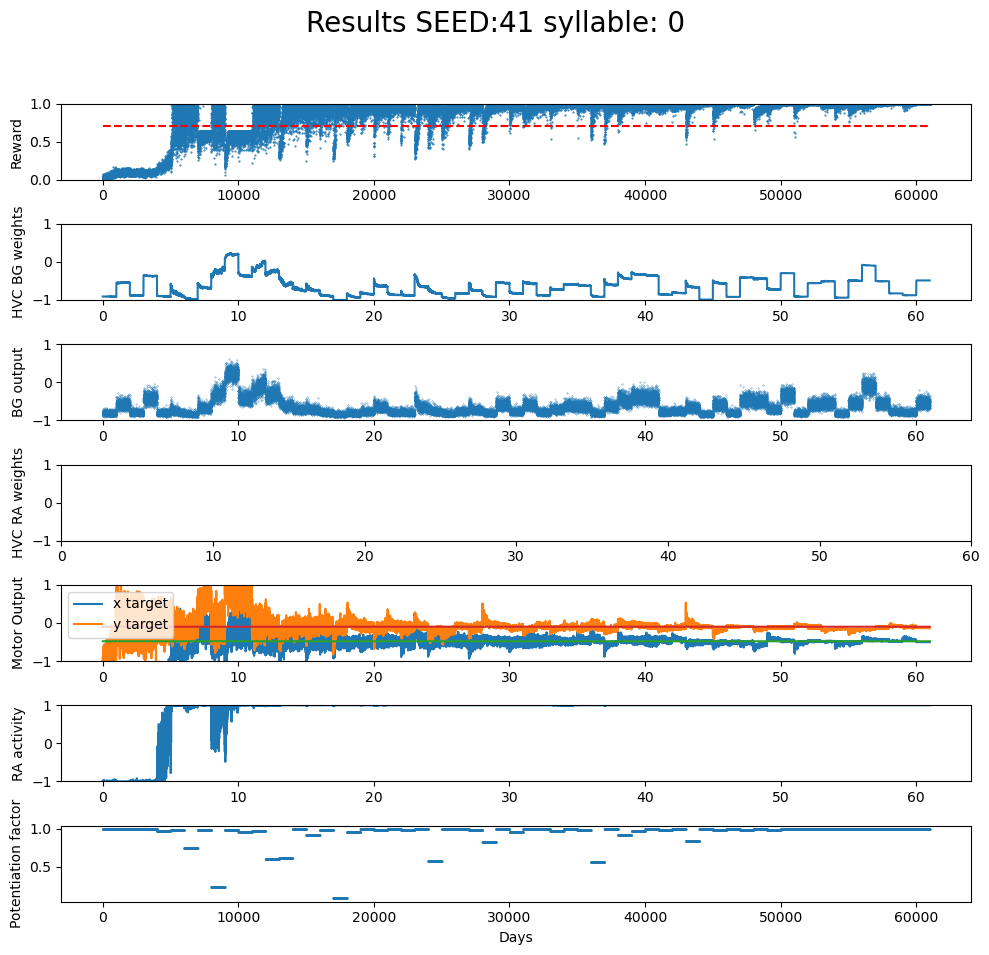

In [9]:
def plot_interal_all(obj, syll):
    fig, ax = plt.subplots(7, 1, figsize=(10, 10))  
    
    ax[0].plot(obj.rewards[:, :, syll].reshape(obj.DAYS * obj.TRIALS), '.', markersize=1, linestyle='None')
    ax[0].hlines(0.7, 0, obj.DAYS * obj.TRIALS, colors='r', linestyles='dashed')
    ax[0].set_ylim(0, 1)
    ax[0].set_ylabel('Reward')
    
    ax[1].plot(obj.hvc_bg_array[:, :, syll].reshape(obj.DAYS * obj.TRIALS))
    ax[1].set_ylim(-1, 1)
    ax[1].set_ylabel('HVC BG weights')
    
    ax[2].plot(obj.bg_out[:, :, syll].reshape(obj.DAYS * obj.TRIALS), '.', markersize=0.5, linestyle='None')
    ax[2].set_ylim(-1, 1)
    ax[2].set_ylabel('BG output')
    
    # ax[3].plot(obj.hvc_ra_array_all[:, :, syll, 0, 0].reshape(obj.DAYS * obj.TRIALS))
    ax[3].set_ylim(-1, 1)
    ax[3].set_ylabel('HVC RA weights')
    
    ax[4].plot(obj.actions[:, :, syll, 0].reshape(obj.DAYS * obj.TRIALS))
    ax[4].plot(obj.actions[:, :, syll, 1].reshape(obj.DAYS * obj.TRIALS))
    ax[4].plot(obj.centers[syll, 0] * np.ones(obj.TRIALS * obj.DAYS))
    ax[4].plot(obj.centers[syll, 1] * np.ones(obj.TRIALS * obj.DAYS))
    ax[4].legend(['x target', 'y target'])
    ax[4].set_ylabel('Motor Output')
    ax[4].set_ylim(-1, 1)
    
    ax[5].plot(obj.ra_out[:, :, syll].reshape(obj.DAYS * obj.TRIALS))
    ax[5].set_ylim(-1, 1)
    ax[5].set_ylabel('RA activity')
    ax[6].set_xlabel('Days')
    
    potentiation_factor_all = np.repeat(obj.potentiation_factor_all, N_DAILY_MOTIFS, axis=0)
    ax[6].plot(potentiation_factor_all[:, syll, 0, 0].reshape(obj.DAYS * obj.TRIALS), '.', markersize=1, label='POTENTIATION', alpha=0.1)
    ax[6].set_ylabel('Potentiation factor')
    
    for i in range(1, 6):
        ax[i].set_xticks(range(0, obj.DAYS * obj.TRIALS, 10 * obj.TRIALS), range(0, obj.DAYS, 10))
    
    fig.suptitle(f'Results SEED:{obj.seed} syllable: {syll}', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # type: ignore
    plt.show()


plot_interal_all(obj, 0)

In [10]:

# for i in range(N_SYLL):
#     obj.save_results(i)
    # obj.save_dw_day(i)
    # obj.save_trajectory(i)
    

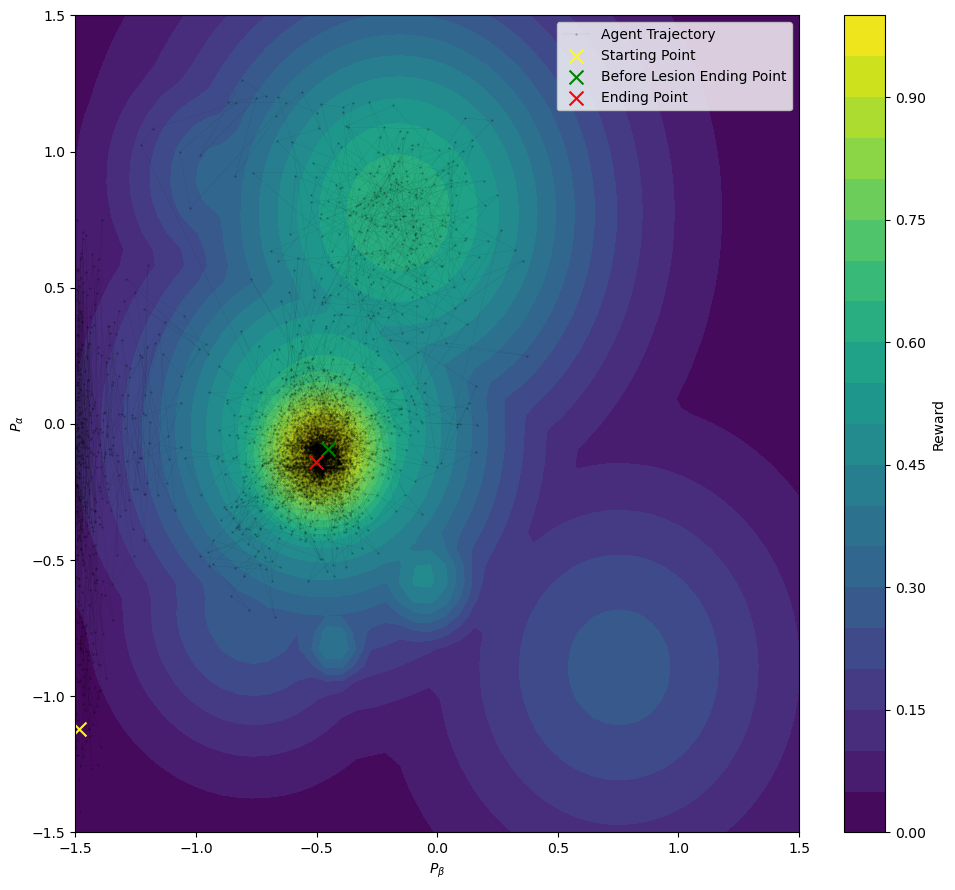

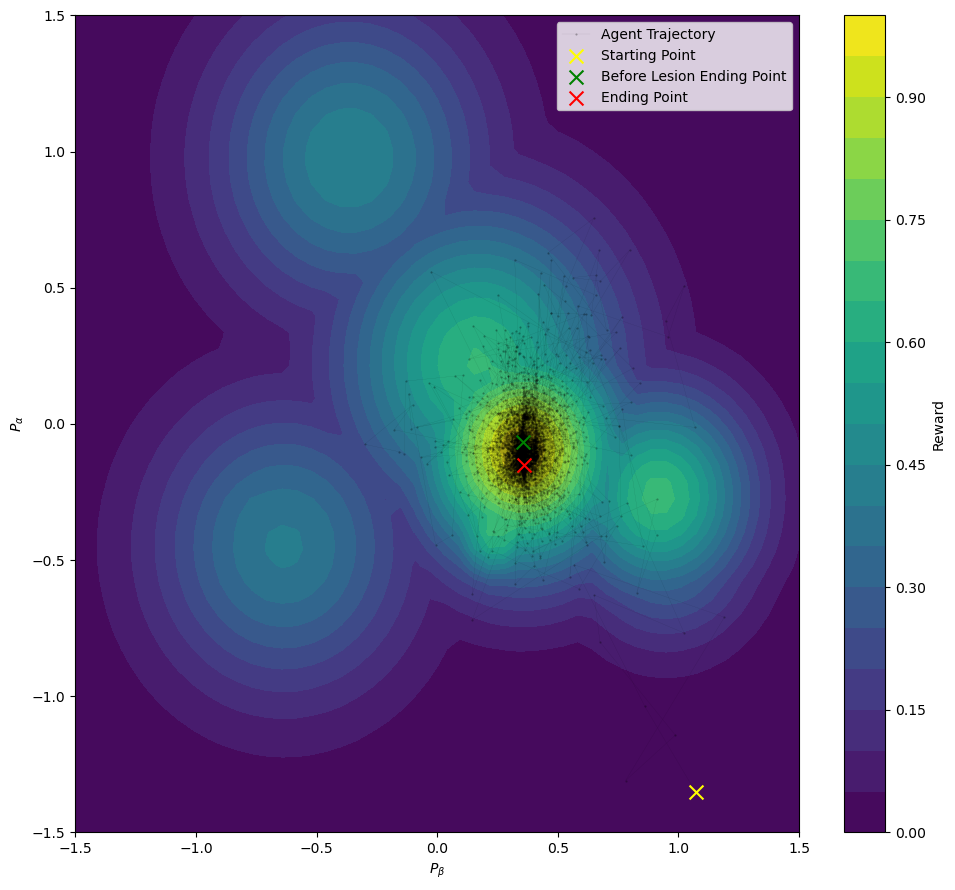

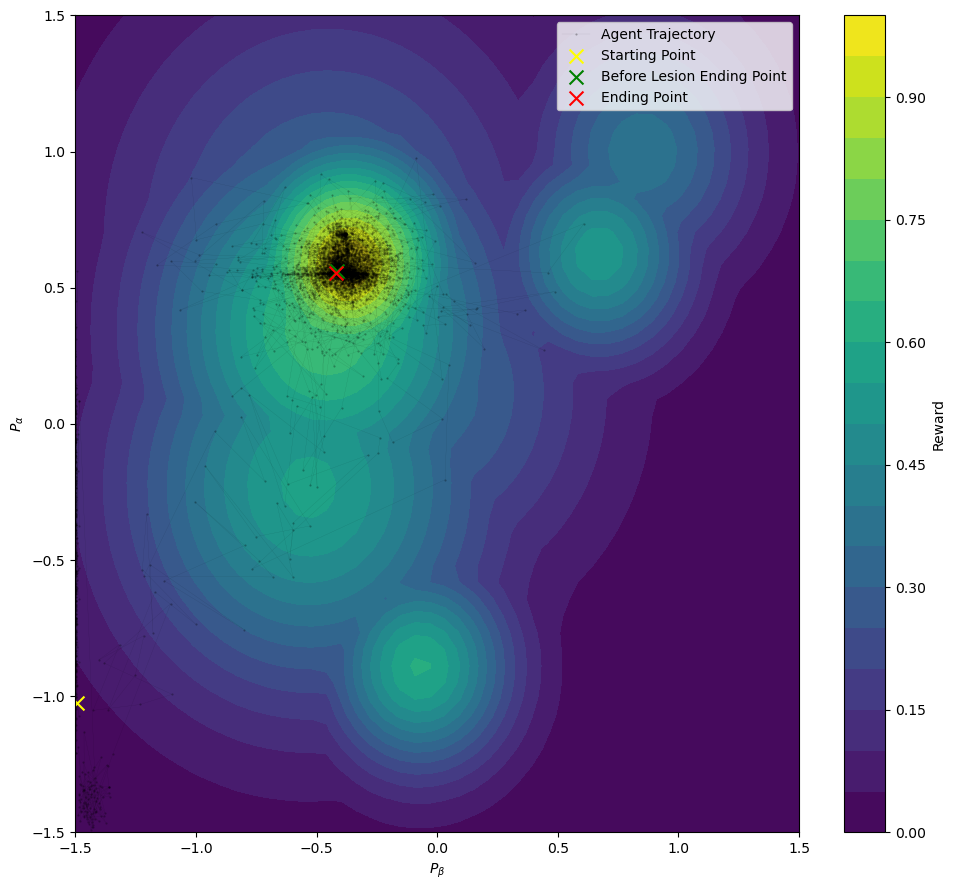

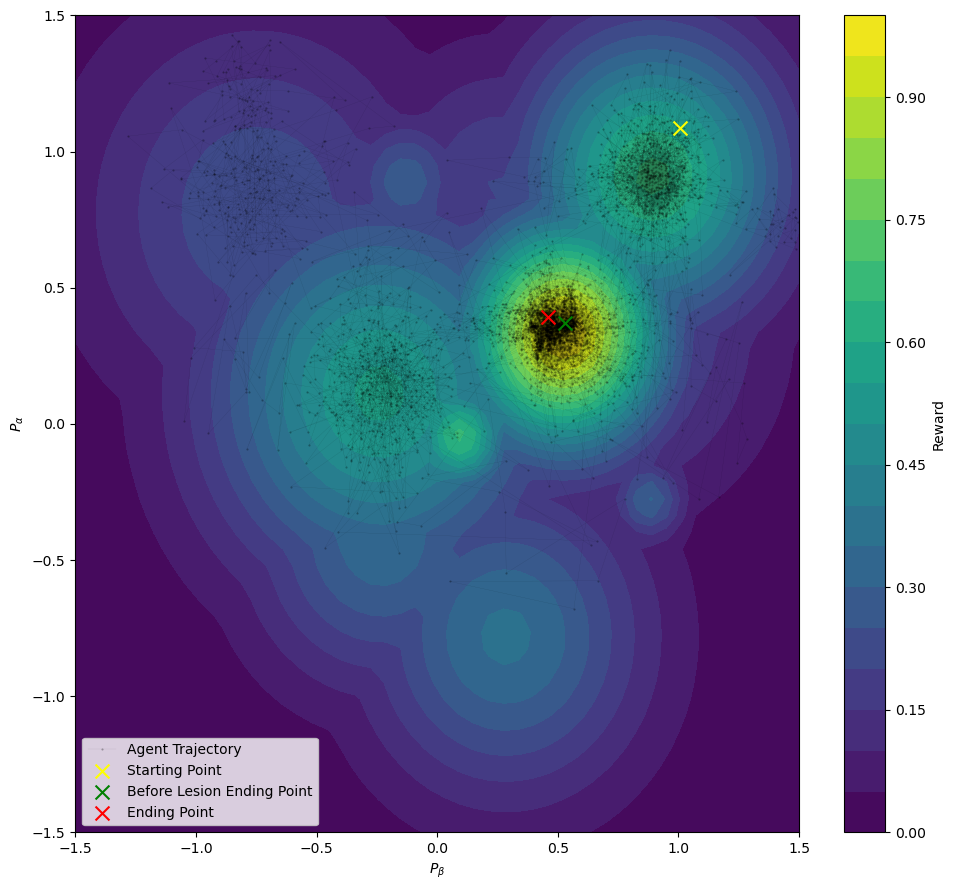

In [11]:
def plot_trajectory(syll):
    fig, axs = plt.subplots(figsize=(10, 9))
    cmap = 'viridis' #LinearSegmentedColormap.from_list('white_to_black', ['white', 'black'])
    if obj.LANDSCAPE == 0: # artificial landscape
        x_traj, y_traj = zip(*obj.actions[:,:, syll,:].reshape(-1, 2))
        limit = obj.limit
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = obj.get_reward([X, Y], syll)
        contour = axs.contourf(X, Y, Z, levels=20, cmap=cmap)
        fig.colorbar(contour, ax=axs, label='Reward')
        # # plot trajectory
        # axs.plot(x_traj[::10], y_traj[::10], 'yellow', label='Agent Trajectory', alpha = 0.1, marker = ".", linewidth = 0.1, markersize = 0.99) # Plot every 20th point for efficiency
        # axs.scatter(x_traj[0], y_traj[0], s=100, c='blue', label='Starting Point', marker = 'x')  # type: ignore # Plot first point as red circle
        # axs.scatter(x_traj[-1001], y_traj[-1001], s=100, c='pink', marker='x', label='Before Lesion Ending Point')
        # axs.scatter(x_traj[-5:], y_traj[-5:], s=100, c='r', marker='x', label='After Leison Point') # type: ignore
        # axs.scatter(obj.centers[syll, 0], obj.centers[syll, 1], s=100, c='green', marker='x', label='target')  # type: ignore
    else:
        Z = obj.syrinx_contours[syll]
        target_pos = obj.syrinx_targets[syll]
        cs = plt.contourf(Z.T, cmap=cmap, extent=[-1, 1, -1, 1])
        fig.colorbar(cs, ax=axs, label='Reward')
        axs.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='target')  # type: ignore
        # plot trajectory
    x_traj, y_traj = zip(*obj.actions[:,:, syll,:].reshape(-1, 2))
    axs.plot(x_traj[::10], y_traj[::10], 'black', label='Agent Trajectory', alpha = 0.3, linewidth = 0.1, marker='.', markersize = 0.99) # Plot every 20th point for efficiency
    axs.scatter(x_traj[0], y_traj[0], s=100, c='yellow', label='Starting Point', marker = 'x',zorder = 2)  # type: ignore # Plot first point as red circle
    axs.scatter(x_traj[-1001], y_traj[-1001], s=100, c='green', marker='x', label='Before Lesion Ending Point', zorder=3)
    axs.scatter(x_traj[-1], y_traj[-1], s=100, c='r', marker='x', label='Ending Point',zorder=3) # type: ignore
    
    # labels
    # axs.set_title(f'Contour plot of reward function SEED:{RANDOM_SEED} syllable: {syll}', fontsize = 15)
    axs.set_ylabel(r'$P_{\alpha}$')
    axs.set_xlabel(r'$P_{\beta}$')
    axs.legend()
    plt.tight_layout()
    plt.show()

expanded_dw_day = np.zeros((DAYS*N_DAILY_MOTIFS))
def plot_dw_day(syll):
    if obj.annealing:
        fig, axs = plt.subplots(5,1,figsize=(6, 10))
        expanded_dw_day_array = np.zeros((DAYS*N_DAILY_MOTIFS, N_SYLL))

        expanded_pot_array = np.zeros((DAYS*N_DAILY_MOTIFS, N_SYLL))

        # Expand dw_day_array and pot_array to match the size of rewards
        expanded_dw_day_array = np.repeat(obj.dw_day_array[:, syll], DAYS*N_DAILY_MOTIFS// len(obj.dw_day_array[:, syll]))
        expanded_dw_day = expanded_dw_day_array.reshape(DAYS*N_DAILY_MOTIFS)
        expanded_pot_array = np.repeat(obj.pot_array[:, syll], DAYS*N_DAILY_MOTIFS// len(obj.pot_array[:, syll]))
        fig.suptitle(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')
        axs[0].plot(expanded_dw_day_array, markersize=1, label='dW_day')
        axs[0].plot(obj.annealing_mids[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
        axs[0].set_ylabel('dW_day = mean(abs(dw_hvc_bg))')         
        axs[0].set_ylim(0,9) 
        axs[1].plot(expanded_pot_array, markersize=1, label='Potentiation factor')
        axs[1].set_ylabel('Size of night jump')
        axs[1].set_ylim(0, 1)
        axs[2].plot(obj.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='Reward', alpha = 0.1)
        axs[2].set_ylabel('Rewards')
        axs[2].set_ylim(0, 1)
        axs[3].plot(obj.RPE[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='RPE', alpha = 0.1)               
        axs[3].set_ylabel('RPE')
        axs[3].set_ylim(-1, 1)
        axs[4].plot(obj.RPE_SUM[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='RPE_SUM', alpha = 0.1)
        axs[4].set_ylabel('RPE sum for a day')
        axs[4].set_ylim(-1, 4)    
        for i in range(5):
            axs[i].vlines(range(0, DAYS*N_DAILY_MOTIFS, N_DAILY_MOTIFS), -3, 10, colors='black', linestyles='dashed', alpha = 0.1)           
        plt.tight_layout()
        plt.show()

for i in range(N_SYLL):
    plot_trajectory(i)

## Plottings

In [12]:
def running_mean(x, N=5):
        """ Returns the running average of an array. """
        rm = np.convolve(x, np.ones(N)/N, mode='valid')
        padded_rm = np.ones(np.shape(x)) * rm[-1]
        padded_rm[:rm.size] = rm

        return padded_rm

### Output

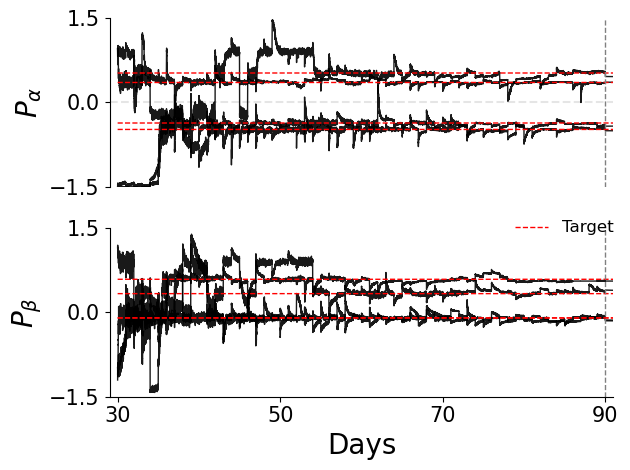

In [13]:
def plot_output(obj):
    figure, (ax1, ax2) = plt.subplots(2,1)
    
    sk = N_SYLL
    LIMIT = 1.5

    # Display x axis in days
    x = np.arange(N_TOTAL_TRIALS)
    x = x/(N_DAILY_MOTIFS * N_SYLL)

    # Plot running average of cortical output (brown), BG output (grey) and total output (black)
    # Data
    for syll in range(N_SYLL):
        # motor outputs
        ax1.plot(running_mean(obj.actions[:,:,syll,0].reshape(DAYS*N_DAILY_MOTIFS), 10), color="black", lw=1, alpha=.9)
        ax2.plot(running_mean(obj.actions[:,:,syll,1].reshape(DAYS*N_DAILY_MOTIFS), 10), color="black", lw=1, alpha=.9)
    
    for syll in range(N_SYLL - 1):
        # target
        ax1.plot(obj.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1)
        ax2.plot(obj.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1)
    if N_SYLL > 1:
        ax1.plot(obj.centers[syll + 1, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1)
        ax2.plot(obj.centers[syll + 1, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1, label = 'Target')
    elif N_SYLL == 1:
        ax1.plot(obj.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1, label = 'Target')
        ax2.plot(obj.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1)
        
    # Axis beauty
    ax1.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    ax2.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)
#         ax1.axhline(y=obj.targetpos[0], linestyle='--', color='black', label='Global optimum')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.get_xaxis().set_ticks([])
    ax1.set_ylim(-LIMIT, LIMIT)
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([-LIMIT, 0, LIMIT])
    ax1.set_xlim(-N_DAILY_MOTIFS, N_DAILY_MOTIFS*DAYS)
    
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([-LIMIT, 0, LIMIT])
    ax2.set_ylim(-LIMIT, LIMIT)
    ax2.tick_params(labelsize=15)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlim(-N_DAILY_MOTIFS, N_DAILY_MOTIFS*DAYS)
    # ax2.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)
    
    ax2.set_ylabel(r'$P_{\beta}$', fontsize=20)
    ax1.set_ylabel(r'$P_{\alpha}$', fontsize=20)
    plt.legend(frameon=False, loc='center right', fontsize=12, bbox_to_anchor=(1.03,1))
    plt.xticks(range(0, N_DAILY_MOTIFS*DAYS, 20*N_DAILY_MOTIFS), np.arange(30, DAYS+30, 20))
    plt.tight_layout()
    plt.show()

plot_output(obj)

### Reward

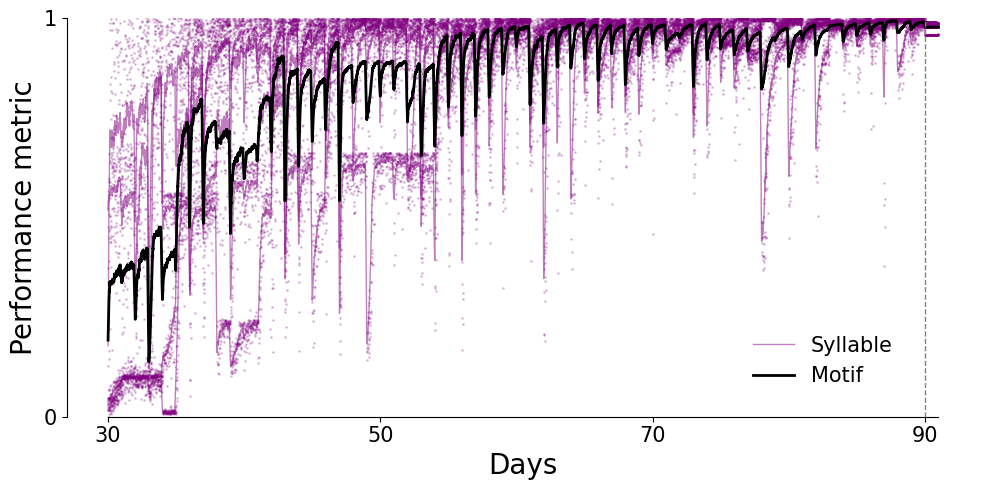

In [14]:
def plot_reward(obj):
    figure, ax = plt.subplots(1, figsize=(10, 5))
    # Display x axis in days

    # ax.set_title("Testing RL with normalized sigmoid")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # plotting rewards 
    for syll in range(N_SYLL):
        array = obj.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS)[::10]
        x_new = np.linspace(0, DAYS*N_DAILY_MOTIFS, len(array))
        ax.plot(x_new, array, linewidth=0, marker='.', color = 'purple', alpha = 0.2, markersize = 2)
    
    for syll in range(N_SYLL - 1):
        ax.plot(running_mean(obj.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), 100), color="purple", lw=1, alpha=0.5)
    if N_SYLL > 1:
        ax.plot(running_mean(obj.rewards[:,:,syll + 1].reshape(DAYS*N_DAILY_MOTIFS), 100), color="purple", lw=1, alpha=0.5, label = 'Syllable')
    elif N_SYLL == 1:
        ax.plot(running_mean(obj.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), 100), color="purple", lw=1, alpha=0.5, label = 'Syllable')
    ax.plot(running_mean(np.mean(obj.rewards[:,:,:].reshape(DAYS*N_DAILY_MOTIFS, N_SYLL), axis=1), 100),  color="black", lw=2, alpha=1, markersize=8, label='Motif')

    ax.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    ax.set_xlabel('Days', fontsize=20)
    ax.set_ylabel('Performance metric', fontsize=20)
    ax.set_ylim(0, 1)
    ax.tick_params(labelsize=15)
    ax.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS)
    ax.set_yticks([0, 1])   
    ax.legend(bbox_to_anchor=[.925,0.25], fontsize=15, frameon=False)
    plt.tight_layout()
    plt.xticks(range(0, N_DAILY_MOTIFS*DAYS, 20*N_DAILY_MOTIFS), np.arange(30, 30+DAYS, 20), fontsize=15) # type: ignore
    plt.tight_layout()
    


plot_reward(obj)

### Hebbian learning trajectory

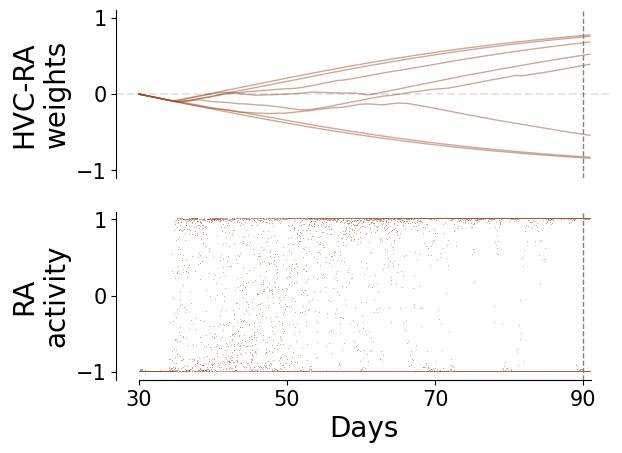

In [15]:
def plot_HL_traj(obj):
    figure, (ax1, ax2) = plt.subplots(2,1)

    # Plot running average of cortical output (brown), BG output (grey) and total output (black)
    plot_array1 = obj.hvc_ra_array_all[:, :, 0, :].reshape(DAYS*N_DAILY_MOTIFS, 8)
    ax1.plot(plot_array1[::10, :], color='sienna', alpha=.5, linewidth=1)

    plot_array2 = obj.ra_all[:, :, 0, :].reshape(DAYS*N_DAILY_MOTIFS, 8)
    ax2.plot(plot_array2[::100, :], color="sienna", alpha=.5, marker=',', linewidth=0, markersize=1)

    
    # # Axis beauty
    ax1.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS//10, linestyle='--', color='grey', lw=1)
    ax2.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS//100, linestyle='--', color='grey', lw=1)
    ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(labelsize=15)
    ax1.set_xticks([])
    ax1.set_yticks([-1, 0, 1])
    ax1.set_ylim(-1.1, 1.1)

    ax2.set_xticks([0, 20*N_DAILY_MOTIFS//100, 40*N_DAILY_MOTIFS//100, 60*N_DAILY_MOTIFS//100], np.arange(30, 30+DAYS, 20)) 
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([-1, 0, 1])
    ax2.tick_params(labelsize=15)

    # ax2.get_xaxis().set_ticks([0, 20, 40, 60])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS//100)



#         if obj.contour_type=='Syrinx':
#             ax1.set_ylabel(r'$P_{\beta} (Tension)$', fontsize=20)
#             ax1.set_ylabel(r'$P_{\alpha} (Pressure)$', fontsize=20)
#         else:
    ax1.set_ylabel('HVC-RA\nweights', fontsize=20)
    ax2.set_ylabel('RA\nactivity', fontsize=20)
    
# print(obj.hvc_ra_array_all.shape)
plot_HL_traj(obj)

### Reinforcement Learning trajectory

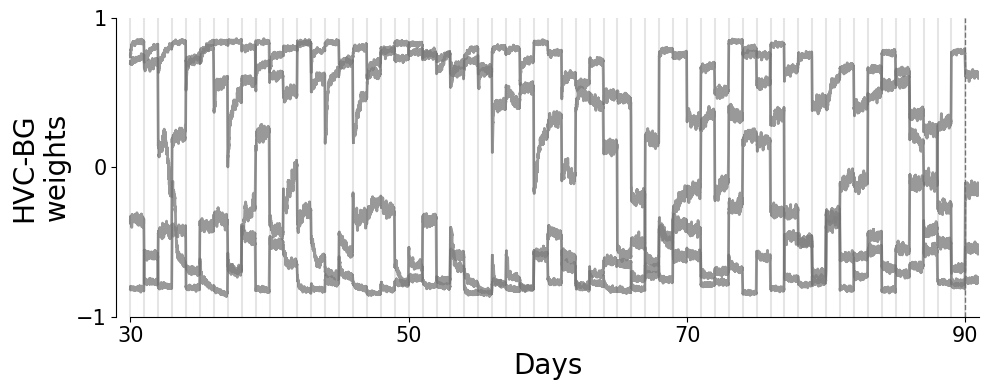

In [16]:
def plot_BG_volatility(obj):
    figure, (ax1) = plt.subplots(1, figsize=(10, 4))
    for syll in range(N_SYLL):
        ax1.plot(running_mean(obj.bg_out[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS),30), color='grey', alpha=0.8, linewidth=2)
    # ax1.plot(running_mean(obj.bg_out[:,:,0].reshape(DAYS*N_DAILY_MOTIFS),30), color='grey', alpha=0.8, linewidth=2) 
    ax1.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)     
    [ax1.axvline(x = k, linestyle='-', color='black', alpha=0.1) for k in range(0, DAYS*N_DAILY_MOTIFS, N_DAILY_MOTIFS)]    
    ax1.set_xlabel('Days', fontsize=20)
    ax1.set_ylabel('BG output', fontsize=20)
    ax1.set_ylim(-1, 1)
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([-1, 0, 1])
    ax1.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)   
    ax1.set_ylim(-1, 1 )
    ax1.set_xlabel('Days', fontsize=20)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS)

#         if obj.contour_type=='Syrinx':
#             ax1.set_ylabel(r'$P_{\beta} (Tension)$', fontsize=20)
#             ax1.set_ylabel(r'$P_{\alpha} (Pressure)$', fontsize=20)
#         else:
    ax1.set_ylabel('HVC-BG\nweights', fontsize=20)
#         ax2.set_ylabel('BG\nactivity', fontsize=20)

#         ax1.set_ylabel(r'$P_{\alpha}$', fontsize=20)
    
#         plt.legend(frameon=False, loc='center right', fontsize=12, bbox_to_anchor=(1.03,1))
    plt.xticks(range(0, N_DAILY_MOTIFS*DAYS, 20*N_DAILY_MOTIFS), np.arange(30,30+ DAYS, 20))    
    plt.tight_layout()

plot_BG_volatility(obj)

### Hebbian Learning Activity

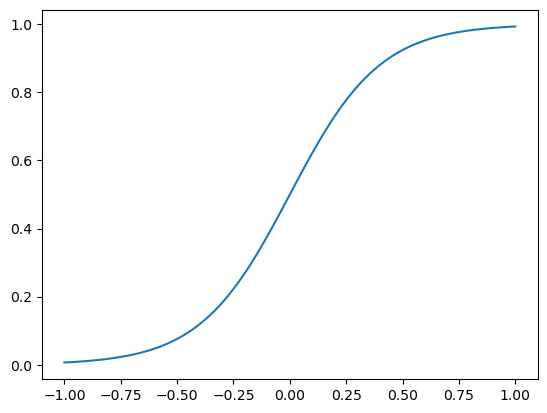

In [19]:
x_vals = np.linspace(-1, 1, 100)

plt.plot(x_vals, sigmoid(x_vals, m=5, a=0))
plt.show()

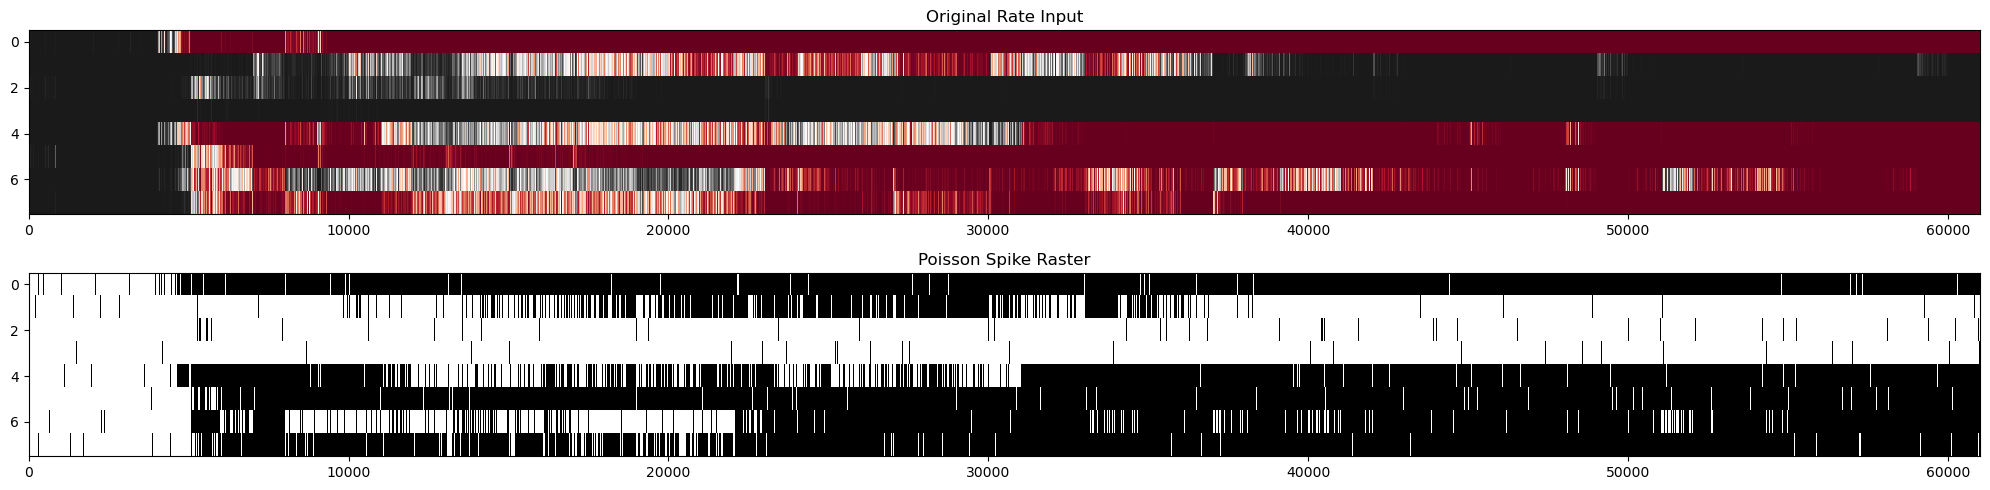

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# # Sigmoid function
# def sigmoid(x, m=3, a=0):
#     return 1 / (1 + np.exp(-m * (x - a)))

# Generate Poisson spikes from a 2D rate array
def generate_poisson_spikes(rate_array, dt=1):
    return (np.random.rand(*rate_array.shape) < (rate_array * dt)).astype(int)

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 5))

# Reshape your input array
array1 = obj.ra_all.reshape(DAYS * N_DAILY_MOTIFS, N_SYLL, 8)[:, :]

# Show original rate (1st channel)
axs[0].imshow(array1[:, 0, :].T, aspect='auto', cmap='RdGy_r', interpolation='nearest')
axs[0].set_title("Original Rate Input")

# Generate spike raster from sigmoid-transformed rates
# rate_input = sigmoid(array1[:, 0, :].T, m=4, a=0)
spike_raster = generate_poisson_spikes(sigmoid(array1[:, 0, :].T, m=4, a=0))

# Show spikes
im = axs[1].imshow(spike_raster, aspect='auto', cmap='Greys', interpolation='nearest')
axs[1].set_title("Poisson Spike Raster")

plt.tight_layout()
plt.show()


/tmp/ipykernel_66170/4215275580.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('RdGy_r')
/tmp/ipykernel_66170/4215275580.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


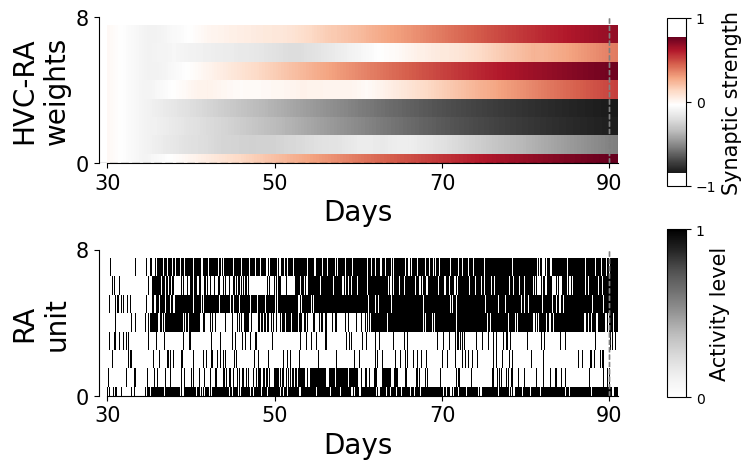

In [46]:

def plot_HL2(obj):
    figure, (ax1, ax2) = plt.subplots(2,1)
    ax1.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    ax2.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    cm = plt.cm.get_cmap('RdGy_r')

    plot_array1 = obj.hvc_ra_array_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, 8)
    im1 = ax1.imshow(plot_array1[:,0,:].T, cmap=cm, aspect='auto', interpolation='none')

    plot_array2 = obj.ra_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, 8)
    spike_raster = generate_poisson_spikes(sigmoid(plot_array2[:, 0, :].T, m=2, a=0), dt = 1)
    im2 = ax2.imshow(spike_raster, aspect='auto', cmap='Greys', interpolation='nearest')

    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.05, 0.6, 0.03, 0.35]) # type: ignore
    cbar = figure.colorbar(im1, cax=cbar_ax)
    cbar.set_label('Synaptic strength', fontsize=15)
    cbar.set_ticks([-1, 0, 1])
    
    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.05, 0.16, 0.03, 0.35]) # type:ignore
    cbar = figure.colorbar(im2, cax=cbar_ax)
    cbar.set_label('Activity level', fontsize=15)
    cbar.set_ticks([0, 1])

    ax1.vlines(N_DAYS_INTACT * N_DAILY_MOTIFS, 0, 8, color='grey', linestyle='--', lw=1)   
    ax2.vlines(N_DAYS_INTACT * N_DAILY_MOTIFS, 0, 8, color='grey', linestyle='--', lw=1)
    ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS, 60*N_DAILY_MOTIFS], np.arange(30, 30 + DAYS, 20))     
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([0, 8])
    ax1.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)
    ax1.set_ylim(0, 8)
    ax1.set_xlabel('Days', fontsize=20)
    ax1.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS)
    ax2.set_ylim(0, 8)
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([0, 8])
    ax2.tick_params(labelsize=15)
    ax2.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS, 60*N_DAILY_MOTIFS], np.arange(30, 30 + DAYS, 20)) 
    ax2.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS) 

    ax1.set_ylabel('HVC-RA\nweights', fontsize=20)
    ax2.set_ylabel('RA\nunit', fontsize=20) 
    plt.tight_layout()



# print(obj.hvc_ra_array_all.shape)    
# print(obj.hvc_ra_array_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, obj.hvc_size*obj.ra_size).shape)
plot_HL2(obj)



### Reinforcement learning Activity

/tmp/ipykernel_66170/3939924132.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('Greys')
/tmp/ipykernel_66170/3939924132.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


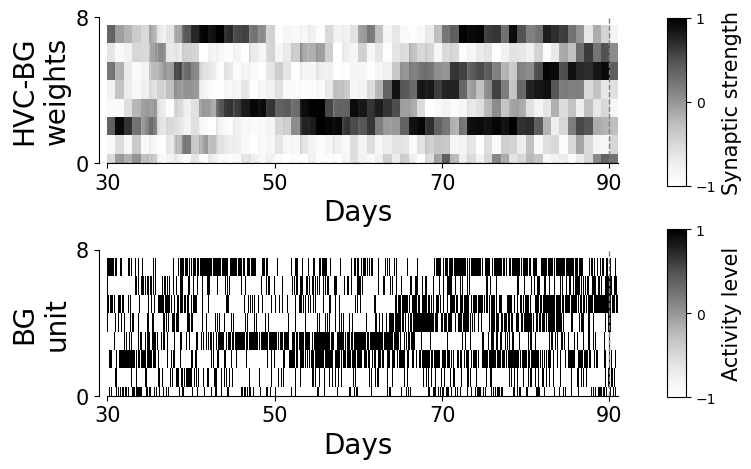

In [43]:
def plot_BG(obj):
    figure, (ax1, ax2) = plt.subplots(2,1)

    cm = plt.cm.get_cmap('Greys')
    plot_array1 = obj.hvc_bg_array_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, 8)
    im1 = ax1.imshow(plot_array1[:,0,:10].T, cmap=cm, aspect='auto', interpolation='none')
    plot_array2 = obj.bg_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, 8)
    spike_raster = generate_poisson_spikes(sigmoid(plot_array2[:, 0, :].T, m=2, a=0))
    im2 = ax2.imshow(spike_raster, aspect='auto', cmap='Greys', interpolation='nearest')
    # im2 = ax2.imshow(plot_array2[:,0,:10].T, cmap=cm, aspect='auto', interpolation='none')  

    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.05, 0.6, 0.03, 0.35])
    cbar = figure.colorbar(im1, cax=cbar_ax)
    cbar.set_label('Synaptic strength', fontsize=15)
    cbar.set_ticks([-1, 0, 1])
    
    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.05, 0.16, 0.03, 0.35])
    cbar = figure.colorbar(im1, cax=cbar_ax)
    cbar.set_label('Activity level', fontsize=15)
    cbar.set_ticks([-1, 0, 1])

    ax1.vlines(N_DAYS_INTACT * N_DAILY_MOTIFS, 0, 10, color='grey', linestyle='--', lw=1)   
    ax2.vlines(N_DAYS_INTACT * N_DAILY_MOTIFS, 0, 10, color='grey', linestyle='--', lw=1)
    ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS, 60*N_DAILY_MOTIFS], np.arange(30, 30 + DAYS, 20))     
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([0, 8])
    ax1.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)
    ax1.set_ylim(0, 8)
    ax1.set_xlabel('Days', fontsize=20)
    ax1.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS)
    ax2.set_ylim(0, 8)
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([0, 8])
    ax2.tick_params(labelsize=15)
    ax2.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS, 60*N_DAILY_MOTIFS], np.arange(30, 30 + DAYS, 20)) 
    ax2.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS) 

    ax1.set_ylabel('HVC-BG\nweights', fontsize=20)
    ax2.set_ylabel('BG\nunit', fontsize=20)
    plt.tight_layout()
    

plot_BG(obj)

In [51]:
obj.ra_all[0, :,:,1].shape

(1000, 4)

/tmp/ipykernel_66170/2908072782.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('RdGy_r')
/tmp/ipykernel_66170/2908072782.py:15: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 2 Axes> than <Figure size 600x500 with 2 Axes> which fig.colorbar is called on.
  cbar = figure.colorbar(im, cax=cbar_ax)
/tmp/ipykernel_66170/2908072782.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_66170/2908072782.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('RdGy_r')
/t

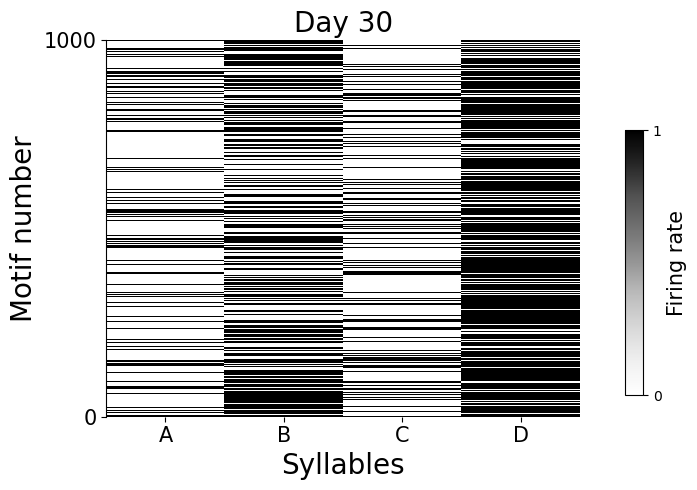

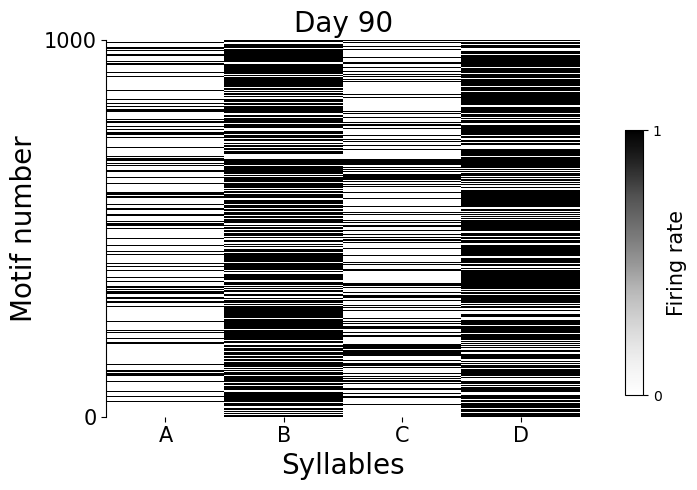

In [66]:
def plot_HL_motifs_on_day(obj, day):
    """ Plots the model output over time. """
    alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']  
    figure, (ax1) = plt.subplots(1, figsize=(6,5))

    cm = plt.cm.get_cmap('RdGy_r')
    plot_array = obj.ra_all[day, :, :, 1].reshape(N_DAILY_MOTIFS, N_SYLL)
    spike_raster = generate_poisson_spikes(sigmoid(plot_array, m=1, a=0), 1)
    im1 = ax1.imshow(spike_raster, aspect='auto', cmap='Greys', interpolation='nearest')

    # im = ax1.imshow(plot_array, cmap=cm, aspect='auto', interpolation='none')

    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.05, 0.2, 0.03, 0.53])
    cbar = figure.colorbar(im, cax=cbar_ax)
    cbar.set_label('Firing rate', fontsize=15)
    cbar.set_ticks([0, 1])

    ax1.set_ylim(0, 1000)
    ax1.set_yticks([1000, 0])
    ax1.tick_params(labelsize=15)
    ax1.set_xticks(range(N_SYLL), [i for i in alphabets[:N_SYLL]])
    ax1.set_xlabel('Syllables', fontsize=20)    
    ax1.set_ylabel('Motif number', fontsize=20)
    ax1.set_title(f'Day {day+30}', fontsize=20)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)  
    ax1.spines['bottom'].set_visible(False)
    plt.tight_layout()

plot_HL_motifs_on_day(obj, 0) 
plot_HL_motifs_on_day(obj, 60)
# print(obj.ra_all.shape) 

/tmp/ipykernel_66170/805242529.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('RdGy_r')
/tmp/ipykernel_66170/805242529.py:15: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 2 Axes> than <Figure size 600x500 with 2 Axes> which fig.colorbar is called on.
  cbar = figure.colorbar(im, cax=cbar_ax)
/tmp/ipykernel_66170/805242529.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


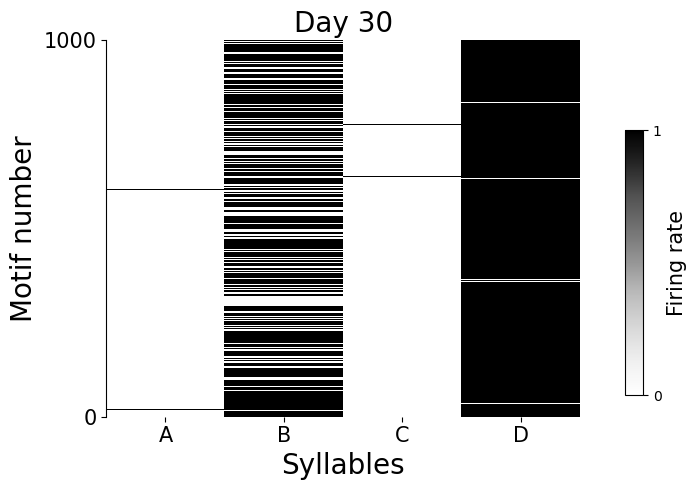

In [ ]:
# def plot_HL_motifs_on_day(obj, day):
#     """ Plots the model output over time. """
#     alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']  
#     figure, (ax1) = plt.subplots(1, figsize=(6,5))

#     cm = plt.cm.get_cmap('RdGy_r')
#     plot_array = obj.bg_all[day, :, :, 1].reshape(N_DAILY_MOTIFS, N_SYLL)
#     im = ax1.imshow(plot_array, cmap=cm, aspect='auto', interpolation='none')

#     figure.subplots_adjust(right=1.2)
#     cbar_ax = figure.add_axes([1.05, 0.2, 0.03, 0.53])
#     cbar = figure.colorbar(im, cax=cbar_ax)
#     cbar.set_label('Firing rate', fontsize=15)
#     cbar.set_ticks([-1, 0, 1])

#     ax1.set_ylim(0, 1000)
#     ax1.set_yticks([1000, 0])
#     ax1.tick_params(labelsize=15)
#     ax1.set_xticks(range(N_SYLL), [i for i in alphabets[:N_SYLL]])
#     ax1.set_xlabel('Syllables', fontsize=20)    
#     ax1.set_ylabel('Motif number', fontsize=20)
#     ax1.set_title(f'Day {day}', fontsize=20)

#     ax1.spines['top'].set_visible(False)
#     ax1.spines['right'].set_visible(False)  
#     ax1.spines['bottom'].set_visible(False)
#     plt.tight_layout()


In [21]:
# plot_trajectory(0) 
# plot_trajectory(1)
# # plot_dw_day(0)
# plot_output
        
# ra_all = obj.generate_results(i)
# obj.plot_results(i)


# def build_and_run(seed, annealing, plot):
#     tqdm.write(f" Random seed is {seed}")
#     np.random.seed(seed)
#     obj = Environment(HVC_SIZE, BG_SIZE, RA_SIZE, MC_SIZE, RANDOM_SEED)
#     obj.run(LEARING_RATE_RL, LEARNING_RATE_HL, ANNEALING)
#     remove_prev_files()
#     for i in range(N_SYLL):
#         obj.save_trajectory(i)
#         obj.save_results(i)
#         if ANNEALING:
#             obj.save_dw_day(i)
#     return np.mean(obj.rewards[:,-100:], axis=1)